In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyLPD import MLtools as mlt
from glob import glob
from matplotlib import rcParams
from scipy import optimize, constants, stats
from SettingPLOTs import *

np.seterr(divide='ignore', invalid='ignore')

ModuleNotFoundError: No module named 'pyLPD'

In [3]:
path_dint = '/home/marvyn/GDrive/m144595@dac.unicamp.br/LPD Team/Papers/Journals/2020 - Marvyn - Tailoring GVD/Figures/Figure 4/All-Data-Dispersion/'
path_ofc = '/home/marvyn/GDrive/m144595@dac.unicamp.br/LPD Team/Experiments/Microspheres/2019-10-17_Sphere_Al2O3_120nm_OFCs/'

dint = pd.read_csv(glob(path_dint + '*73.csv')[0])
ofc = pd.read_pickle(sorted(glob(os.path.join(path_ofc,'*Big-OFC*.pkl')), key=os.path.getmtime)[2])

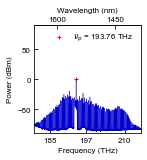

In [4]:
ofc['freq (THz)'] = 1e-3*constants.c / ofc['λ (nm)']

ν_p = ofc['freq (THz)'][ofc['Power (dBm)'].idxmax()] # laser pump wavelength

fig, ax = plt.subplots(figsize=cm2inch(4.85,5.05))

ax.plot(ofc['freq (THz)'], ofc['Power (dBm)'], c='mediumblue', lw=0.4)
ax.scatter(ν_p, ofc['Power (dBm)'].max(), s=10, color='r', marker='+', alpha=1, label=r'$ν_p$ = {:.2f} THz'.format(ν_p,1))

ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Power (dBm)')
ax.set_xlim(179.8,215.3)
ax.set_ylim(-90,90)

freq_ticks = [185, 197, 210]
ax.set_xticks(freq_ticks)

def invert(x):
    return 1e-3*constants.c / x

ax2 = ax.secondary_xaxis('top', functions=(invert, invert))
# ax2.set_ticks(np.round(1e-3*constants.c/np.array(freq_ticks),0))
ax2.set_ticks([1450, 1600])
ax2.set_xlabel('Wavelength (nm)')

plt.legend(loc='best', frameon=False, framealpha=1)
# plt.savefig('OFC.svg')
plt.show()

We should expand in Taylor around the resonance frequency who is producing the OFC.

From the linear spectrum is possible to know this resonance frequency $\nu_0$ = 193.87 THz.

OFC is produced with high input power (~ 65 mW), so the ressonance peak with this power shoul be shifted respect to $\nu_0$, so take care about it.

In this case is better to use the mode number, so:
- Set $\mu$ = 0 at $\nu_0$ for dispersion curve.
- Set the OFC peak as $\mu$ = 0 and compare the OFC with dispersion curve.

In [5]:
dint.head(2)

,μ,Δν (THz),ν (THz),Q-factor
0,-30.0,-8.408800,186.899322,7.941913
1,-29.0,-8.118852,187.189270,9.754975


In [6]:
f0_comb = 193.87 # in THz --- resonance frequency of the mode who is producing the comb

μ0_idx = np.where(abs(dint['ν (THz)']-f0_comb)==min(abs(dint['ν (THz)']-f0_comb)))[0][0]

f0 = dint['ν (THz)'][μ0_idx]
dint['μ'] = dint['μ']-dint['μ'][μ0_idx]
dint['Δν (THz)'] = dint['ν (THz)'] - dint['ν (THz)'][μ0_idx]

### Considering $d_4\neq 0$

**Reference**: Photonic chip–based optical frequency comb using soliton Cherenkov radiation.

In the presence of $d_4$, two peaks of Cherenkov radiation may occur at

$$ \mu_\text{DW} = -\frac{2d_3}{d_4} \pm \sqrt{\left(\frac{2d_3}{d_4}\right)^2 - \frac{12d_2}{d_4}} $$

In [7]:
ν_μ = lambda μ, *d: d[0] + d[1]*μ + d[2]/2*μ**2 + d[3]/6*μ**3 + d[4]/24*μ**4

dfit, dcov = optimize.curve_fit(ν_μ, dint['μ'], dint['Δν (THz)'], [1,0,0,0,0])

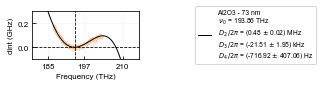

In [8]:
μ_vec = np.arange(-60, 75, 1)

xmin, xmax = 179.8, 215.3 # in THz
ymin, ymax = -0.1, 0.3 # in GHz

plt.figure(figsize=cm2inch(4.85,2.25))

legenda = 'Al2O3 - 73 nm \n' + \
        r' $\nu_0$ = {:.2f} THz'.format(f0) + '\n' \
        r' $D_2/2\pi$ = ({:.2f} $\pm$ {:.2f}) MHz'.format(1e6*dfit[2], 1e6*np.sqrt(dcov[2,2])) + '\n' \
        r' $D_3/2\pi$ = ({:.2f} $\pm$ {:.2f}) kHz'.format(1e9*dfit[3], 1e9*np.sqrt(dcov[3,3])) + '\n' +\
        r' $D_4/2\pi$ = ({:.2f} $\pm$ {:.2f}) Hz'.format(1e12*dfit[4], 1e12*np.sqrt(dcov[4,4]))

plt.scatter(dint['ν (THz)'], 1e3*(dint['Δν (THz)']-ν_μ(dint['μ'],*[dfit[0], dfit[1], 0, 0, 0])), c='w', s=10, lw=0.5, edgecolors='SandyBrown') # 'SandyBrown'
plt.plot(f0+ν_μ(μ_vec, *dfit), 1e3*ν_μ(μ_vec, *[0, 0, dfit[2], dfit[3], dfit[4]]), c='k', lw=1, label=legenda)
plt.hlines(0, min(f0+ν_μ(μ_vec, *dfit)), max(f0+ν_μ(μ_vec, *dfit)), ls='--', lw=0.8)
plt.vlines(x=f0, ymin=ymin, ymax=ymax, ls='--', lw=0.8)

# def invert(x):
#     return 1e-3*constants.c / x
# ax2 = ax.secondary_xaxis('top', functions=(invert, invert))
# ax2.set_xlabel(r'Wavelength (nm)')

plt.xlim(xmin, xmax)
plt.xticks([185, 197, 210])
plt.ylim(ymin, ymax)
plt.yticks([0, 0.2])
plt.xlabel('Frequency (THz)')
plt.ylabel('dint (GHz)')
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), frameon=True, fontsize='small')
plt.grid(True)

# plt.savefig('Dispersion-73nm-alumina-extrapolating-frequency.svg', bbox_inches='tight')

plt.show()

In [9]:
d2 = dfit[2]
d3 = dfit[3]
d4 = dfit[4]

In [10]:
if d4==0:
    μdw = -3*d2/d3
else:
    μdw = -2*d3/d4 + ((2*d3/d4)**2 - 12*d2/d4)**(1/2)

μdw

47.58161932210715

In [11]:
dint_vec = 1e3*ν_μ(μ_vec, *[0, 0, dfit[2], dfit[3], dfit[4]])

idx_μdw =  np.where(dint_vec==np.sort(np.abs(dint_vec))[13])[0][0]

freq_comb = f0+ν_μ(μ_vec, *dfit)

freq_comb[idx_μdw]

207.48662674630037

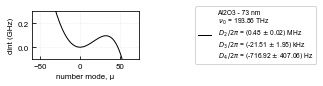

In [12]:
plt.figure(figsize=cm2inch(4.85,2.25))

legenda = 'Al2O3 - 73 nm \n' + \
        r' $\nu_0$ = {:.2f} THz'.format(f0) + '\n' \
        r' $D_2/2\pi$ = ({:.2f} $\pm$ {:.2f}) MHz'.format(1e6*dfit[2], 1e6*np.sqrt(dcov[2,2])) + '\n' \
        r' $D_3/2\pi$ = ({:.2f} $\pm$ {:.2f}) kHz'.format(1e9*dfit[3], 1e9*np.sqrt(dcov[3,3])) + '\n' +\
        r' $D_4/2\pi$ = ({:.2f} $\pm$ {:.2f}) Hz'.format(1e12*dfit[4], 1e12*np.sqrt(dcov[4,4]))

# plt.scatter(dint['ν (THz)'], 1e3*(dint['Δν (THz)']-ν_μ(dint['μ'],*[dfit[0], dfit[1], 0, 0, 0])), c='w', s=10, lw=0.5, edgecolors='SandyBrown') # 'SandyBrown'
plt.plot(μ_vec, 1e3*ν_μ(μ_vec, *[0, 0, dfit[2], dfit[3], dfit[4]]), c='k', lw=1, label=legenda)
# plt.hlines(0, min(f0+ν_μ(μ_vec, *dfit)), max(f0+ν_μ(μ_vec, *dfit)), ls='--', lw=0.8)
# plt.vlines(x=f0, ymin=ymin, ymax=ymax, ls='--', lw=0.8)

# plt.xlim(xmin, xmax)
# plt.xticks([185, 197, 210])
plt.ylim(ymin, ymax)
plt.yticks([0, 0.2])
plt.xlabel('number mode, μ')
plt.ylabel('dint (GHz)')
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), frameon=True, fontsize='small')
plt.grid(True)

# plt.savefig('Dispersion-73nm-alumina-extrapolating-mode-number.svg', bbox_inches='tight')

plt.show()

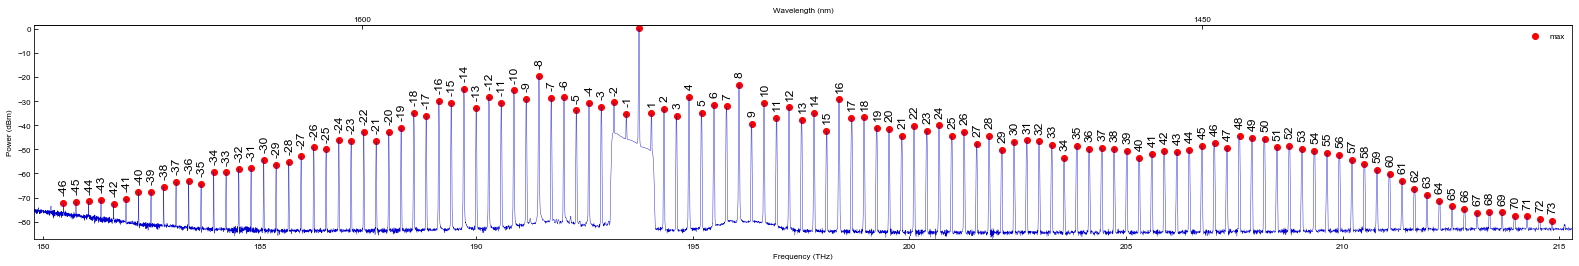

In [13]:
posmax, maxtab, posmin, mintab = mlt.peakdet(ofc['Power (dBm)'].values, 4)

fig, ax = plt.subplots(figsize=cm2inch(70,10))

ax.plot(ofc['freq (THz)'], ofc['Power (dBm)'], c='mediumblue', lw=0.4)
# ax.scatter(ν_p, ofc['Power (dBm)'].max(), s=10, color='r', marker='+', alpha=1, label=r'$ν_p$ = {:.2f} THz'.format(ν_p,1))
plt.scatter(ofc['freq (THz)'][posmax], maxtab, color='r', label='max') # plt max

ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Power (dBm)')
ax.set_xlim(179.8,215.3)
# ax.set_ylim(-90,90)

# freq_ticks = [185, 197, 210]
# ax.set_xticks(freq_ticks)

def invert(x):
    return 1e-3*constants.c / x

ax2 = ax.secondary_xaxis('top', functions=(invert, invert))
# ax2.set_ticks(np.round(1e-3*constants.c/np.array(freq_ticks),0))
ax2.set_ticks([1450, 1600])
ax2.set_xlabel('Wavelength (nm)')

ax = plt.gca()
for ii in range(len(maxtab)):
    ax.annotate(-(ii-73), (ofc['freq (THz)'][posmax[ii]]-0.1, maxtab[ii]+4), rotation=90, fontsize='12')

plt.legend(loc='best', frameon=False, framealpha=1)
# plt.savefig('OFC-peaks.svg')
plt.show()

In [14]:
μ_DW_idx = -(48-73)
ofc['freq (THz)'][posmax[μ_DW_idx]]

207.62400231515002

In [15]:
d2 = 480.0
d3 = -22.0
d4 = -0.7

μdw = -2*d3/d4 + ((2*d3/d4)**2 - 12*d2/d4)**(1/2)
μdw

47.50404523330266

----
----

### Considering $d_4=0$

**Reference**: Photonic chip–based optical frequency comb using soliton Cherenkov radiation.

The spectral position of the Cherenkov radiation is approximately given by the linear phase-matching condition $d_\text{int}(\mu_\text{DW})=0$ at $\mu_\text{DW}=(-3d_2/d_3)$ for $d_4=0$.

In [16]:
ν_μ = lambda μ, *d: d[0] + d[1]*μ + d[2]/2*μ**2 + d[3]/6*μ**3

dfit, dcov = optimize.curve_fit(ν_μ, dint['μ'], dint['Δν (THz)'], [1,0,0,0])

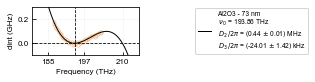

In [17]:
μ_vec = np.arange(-60, 75, 1)

xmin, xmax = 179.8, 215.3 # in THz
ymin, ymax = -0.1, 0.3 # in GHz

plt.figure(figsize=cm2inch(4.85,2.25))

legenda = 'Al2O3 - 73 nm \n' + \
        r' $\nu_0$ = {:.2f} THz'.format(f0) + '\n' \
        r' $D_2/2\pi$ = ({:.2f} $\pm$ {:.2f}) MHz'.format(1e6*dfit[2], 1e6*np.sqrt(dcov[2,2])) + '\n' \
        r' $D_3/2\pi$ = ({:.2f} $\pm$ {:.2f}) kHz'.format(1e9*dfit[3], 1e9*np.sqrt(dcov[3,3]))

plt.scatter(dint['ν (THz)'], 1e3*(dint['Δν (THz)']-ν_μ(dint['μ'],*[dfit[0], dfit[1], 0, 0])), c='w', s=10, lw=0.5, edgecolors='SandyBrown') # 'SandyBrown'
plt.plot(f0+ν_μ(μ_vec, *dfit), 1e3*ν_μ(μ_vec, *[0, 0, dfit[2], dfit[3]]), c='k', lw=1, label=legenda)
plt.hlines(0, min(f0+ν_μ(μ_vec, *dfit)), max(f0+ν_μ(μ_vec, *dfit)), ls='--', lw=0.8)
plt.vlines(x=f0, ymin=ymin, ymax=ymax, ls='--', lw=0.8)

# def invert(x):
#     return 1e-3*constants.c / x
# ax2 = ax.secondary_xaxis('top', functions=(invert, invert))
# ax2.set_xlabel(r'Wavelength (nm)')

plt.xlim(xmin, xmax)
plt.xticks([185, 197, 210])
plt.ylim(ymin, ymax)
plt.yticks([0, 0.2])
plt.xlabel('Frequency (THz)')
plt.ylabel('dint (GHz)')
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), frameon=True, fontsize='small')
plt.grid(True)

# plt.savefig('Dispersion-73nm-alumina-extrapolating-frequency-without-d4.svg', bbox_inches='tight')

plt.show()

In [18]:
d2 = dfit[2]
d3 = dfit[3]

In [19]:
μdw = -3*d2/d3
μdw

55.04723929459577

It is not consistent with OFC spectrum!!!

79
199.36767029507655


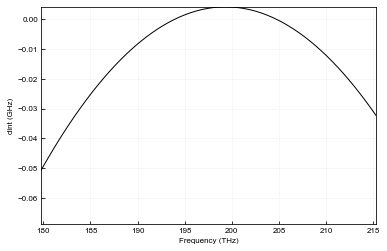

In [47]:
fvec = 1e3*ν_μ(μ_vec, *[0, 0, dfit[2], dfit[3]])

# plt.scatter(dint['ν (THz)'], 1e3*(dint['Δν (THz)']-ν_μ(dint['μ'],*[dfit[0], dfit[1], 0, 0])), c='w', s=10, lw=0.5, edgecolors='SandyBrown') # 'SandyBrown'
plt.plot(f0+ν_μ(μ_vec, *dfit), np.diff(fvec, prepend=fvec[0]), c='k', lw=1, label=legenda)
print(np.where(np.diff(fvec, prepend=fvec[0])==np.diff(fvec, prepend=fvec[0]).max())[0][0])
print(f0+ν_μ(μ_vec, *dfit)[79])
# plt.hlines(0, min(f0+ν_μ(μ_vec, *dfit)), max(f0+ν_μ(μ_vec, *dfit)), ls='--', lw=0.8)
# plt.vlines(x=f0, ymin=ymin, ymax=ymax, ls='--', lw=0.8)

plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
plt.xlabel('Frequency (THz)')
plt.ylabel('dint (GHz)')
# plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), frameon=True, fontsize='small')
plt.grid(True)

# plt.savefig('Dispersion-73nm-alumina-extrapolating-frequency-without-d4-diff.svg', bbox_inches='tight')

plt.show()

In [48]:
(199.37-197)*13.76/13

2.508553846153851

### First comb lines

$$\mu = \sqrt{\frac{\kappa}{2\pi d_2}}$$

From the recognized mode fitting $\kappa$ = 11,2 MHz and from dispersion fitting $d_2$ = 440 kHz we have $\mu = 5$